<a href="https://colab.research.google.com/github/hibadash/-Breast-Ultrasound-Classification-Using-Xception-CNN-BUSI-Dataset/blob/ModelTraining/notebooks/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 02 — Entraînement du modèle Xception

Ce notebook contient le code complet pour entraîner le modèle Xception CNN sur le dataset BUSI.

## Objectifs:
- Charger et préparer les données
- Configurer les hyperparamètres (learning rate, batch size, epochs)
- Entraîner le modèle avec callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
- Visualiser les résultats d'entraînement
- Sauvegarder le meilleur modèle

In [39]:
# Cloner le repo GitHub dans un dossier local "breast_project"
import os

# Vérifie si le dossier "breast_project" existe, sinon clone dedans
if not os.path.exists("breast_project"):
    !git clone https://github.com/hibadash/-Breast-Ultrasound-Classification-Using-Xception-CNN-BUSI-Dataset.git breast_project

# Aller dans le dossier cloné (utiliser le chemin absolu pour éviter les imbrications)
import os
breast_project_path = os.path.abspath("breast_project")
os.chdir(breast_project_path)

# Vérifier qu'on est dans le bon répertoire
print(f" Répertoire courant: {os.getcwd()}")
print(f" Contenu du projet:")
!ls

Cloning into 'breast_project'...
remote: Enumerating objects: 5392, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 5392 (delta 29), reused 29 (delta 14), pack-reused 5333 (from 1)
Receiving objects: 100% (5392/5392), 251.99 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (236/236), done.
Updating files: 100% (4102/4102), done.
 Répertoire courant: /content/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project
 Contenu du projet:
app  data  notebooks  overview	README.md  requirements.txt  results  src


In [40]:
# Installer les dépendances si nécessaire
!pip install -q tensorflow>=2.15 numpy pandas matplotlib seaborn scikit-learn

In [41]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
    CSVLogger,
    TensorBoard
)

# Afficher les versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Python version: {sys.version}")

# Vérifier la disponibilité du GPU
print(f"\nGPU disponible: {tf.config.list_physical_devices('GPU')}")
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté")
else:
    print("Pas de GPU")


TensorFlow version: 2.19.0
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU détecté


In [42]:
# =======================
# HYPERPARAMÈTRES D'ENTRAÎNEMENT
# =======================

# Hyperparamètres principaux
LEARNING_RATE = 1e-4  # Taux d'apprentissage initial
BATCH_SIZE = 32  # Taille du batch
EPOCHS = 50  # Nombre maximum d'epochs
IMAGE_SIZE = (224, 224)  # Taille des images

# Callbacks
PATIENCE_EARLY_STOPPING = 10  # Arrêt anticipé si pas d'amélioration
PATIENCE_LR_REDUCTION = 5  # Réduction du LR si pas d'amélioration

# Fine-tuning (optionnel)
FINE_TUNE_AFTER_EPOCHS = 20  # Commencer le fine-tuning après N epochs
FINE_TUNE_LEARNING_RATE = 1e-5  # LR plus faible pour fine-tuning

# Chemins
DATASET_DIR = 'data/Dataset_BUSI'
RESULTS_DIR = 'results'
MODEL_SAVE_PATH = os.path.join(RESULTS_DIR, 'model_xception_best.h5')
MODEL_FINAL_PATH = os.path.join(RESULTS_DIR, 'model_xception_final.h5')

# Créer le dossier results
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Configuration chargée!")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Epochs max: {EPOCHS}")
print(f"   - Early stopping patience: {PATIENCE_EARLY_STOPPING}")


Configuration chargée!
   - Learning rate: 0.0001
   - Batch size: 32
   - Epochs max: 50
   - Early stopping patience: 10


## Préparation des données

In [43]:
# Vérifier le chemin du dataset AVANT d'importer preprocess.py
import os
print(f"   Vérification du dataset...")
print(f"   Répertoire courant: {os.getcwd()}")
print(f"   Chemin dataset: {DATASET_DIR}")
print(f"   Dataset existe? {os.path.exists(DATASET_DIR)}")

# Importer les générateurs de données depuis preprocess.py
from data.preprocess import (
    train_generator,
    val_generator,
    test_generator
)

# Afficher les informations sur le dataset
print(" INFORMATIONS SUR LE DATASET")
print("="*60)
print(f"Images d'entraînement: {train_generator.samples}")
print(f"Images de validation: {val_generator.samples}")
print(f"Images de test: {test_generator.samples}")
print(f"\nClasses: {sorted(list(train_generator.class_indices.keys()))}")
print(f"Mapping des classes: {train_generator.class_indices}")
print(f"Taille des images: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60)


   Vérification du dataset...
   Répertoire courant: /content/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project/breast_project
   Chemin dataset: data/Dataset_BUSI
   Dataset existe? True
 INFORMATIONS SUR LE DATASET
Images d'entraînement: 3615
Images de validation: 236
Images de test: 237

Classes: ['benign', 'malignant', 'normal']
Mapping des classes: {'benign': 0, 'malignant': 1, 'normal': 2}
Taille des images: (224, 224)
Batch size: 32


## Construction du modèle Xception

In [48]:
# Importer la fonction de création du modèle
from src.model import load_xception_model

# Créer le modèle
num_classes = len(train_generator.class_indices)
print(f"Création du modèle Xception pour {num_classes} classes...")

model = load_xception_model(
    input_shape=(*IMAGE_SIZE, 3),
    num_classes=num_classes,
    trainable=False
)
# Recompiler avec sparse_categorical_crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modèle créé avec succès!")
print(f"\n Statistiques du modèle:")
print(f"   - Paramètres totaux: {model.count_params():,}")
print(f"   - Paramètres entraînables: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Afficher un résumé du modèle
model.summary()

Création du modèle Xception pour 3 classes...
Modèle créé avec succès!

 Statistiques du modèle:
   - Paramètres totaux: 22,045,739
   - Paramètres entraînables: 1,182,723


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_12[0][0]    

 Total params: 22,045,739 (84.10 MB)

 Trainable params: 1,182,723 (4.51 MB)

 Non-trainable params: 20,863,016 (79.59 MB)

## Configuration des callbacks

In [49]:
# Créer tous les callbacks nécessaires
callbacks = [
    # 1. Sauvegarde du meilleur modèle
    ModelCheckpoint(
        filepath=MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1,
    ),

    # 2. Early Stopping
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=PATIENCE_EARLY_STOPPING,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.0001
    ),

    # 3. Réduction automatique du learning rate
    ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.5,  # Réduire le LR de moitié
        patience=PATIENCE_LR_REDUCTION,
        min_lr=1e-7,
        verbose=1
    ),

    # 4. Logger CSV
    CSVLogger(
        filename=os.path.join(RESULTS_DIR, 'training_log.csv'),
        separator=',',
        append=False
    ),

    # 5. TensorBoard (pour Colab, on peut utiliser TensorBoard.dev)
    TensorBoard(
        log_dir=os.path.join(RESULTS_DIR, 'tensorboard_logs'),
        histogram_freq=1,
        write_graph=True,
        update_freq='epoch'
    )
]

print(f" {len(callbacks)} callbacks configurés:")
print("   1. ModelCheckpoint - Sauvegarde du meilleur modèle")
print("   2. EarlyStopping - Arrêt anticipé")
print("   3. ReduceLROnPlateau - Réduction du learning rate")
print("   4. CSVLogger - Log des métriques")
print("   5. TensorBoard - Visualisation avancée")


 5 callbacks configurés:
   1. ModelCheckpoint - Sauvegarde du meilleur modèle
   2. EarlyStopping - Arrêt anticipé
   3. ReduceLROnPlateau - Réduction du learning rate
   4. CSVLogger - Log des métriques
   5. TensorBoard - Visualisation avancée


In [50]:
# Calculer les steps par epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

print("DÉBUT DE L'ENTRAÎNEMENT")
print("="*60)
print(f"Steps par epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print("="*60)
print()

# Lancer l'entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n ENTRAÎNEMENT TERMINÉ!")


DÉBUT DE L'ENTRAÎNEMENT
Steps par epoch: 112
Validation steps: 7

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6602 - loss: 0.8886
Epoch 1: val_accuracy improved from -inf to 0.80357, saving model to results/model_xception_best.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 399ms/step - accuracy: 0.6609 - loss: 0.8868 - val_accuracy: 0.8036 - val_loss: 0.5544 - learning_rate: 1.0000e-04
Epoch 2/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 0.6875 - loss: 0.9298

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.80357
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6875 - loss: 0.9298 - val_accuracy: 0.7902 - val_loss: 0.5653 - learning_rate: 1.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8272 - loss: 0.4407
Epoch 3: val_accuracy improved from 0.80357 to 0.83036, saving model to results/model_xception_best.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8272 - loss: 0.4406 - val_accuracy: 0.8304 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 4/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.7812 - loss: 0.5302
Epoch 4: val_accuracy did not improve from 0.83036
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7812 - loss: 0.5302 - val_accuracy: 0.8214 - val_loss: 0.4174 - learning_rate: 1.0000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8790 - loss: 0.3303
Epoch 5: val_accuracy did not improve from 0.83036
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.8789 - loss: 0.3303 - val_accuracy: 0.8214 - val_loss: 0.3799 - learning_rate: 1.0000e-04
Epoch 6/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.8125 - loss: 0.6021
Epoch 6: val_accuracy did not improve from 0.83036
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.8125 - loss: 0.6021 - val_accuracy: 0.8080 - val_loss: 0.4019 - learning_rate: 1.00

112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - accuracy: 0.8762 - loss: 0.3147 - val_accuracy: 0.8348 - val_loss: 0.3832 - learning_rate: 1.0000e-04
Epoch 8/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.9375 - loss: 0.1555
Epoch 8: val_accuracy did not improve from 0.83482
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9375 - loss: 0.1555 - val_accuracy: 0.8214 - val_loss: 0.4105 - learning_rate: 1.0000e-04
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9023 - loss: 0.2505
Epoch 9: val_accuracy did not improve from 0.83482
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.9023 - loss: 0.2504 - val_accuracy: 0.7946 - val_loss: 0.4797 - learning_rate: 1.0000e-04
Epoch 10/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.9062 - loss: 0.1948
Epoch 10: val_accuracy did not improve from 0.83482

Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.906

112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 198ms/step - accuracy: 0.9259 - loss: 0.2056 - val_accuracy: 0.8393 - val_loss: 0.4294 - learning_rate: 5.0000e-05
Epoch 14/50
  1/112 ━━━━━━━━━━━━━━━━━━━━ 17s 158ms/step - accuracy: 1.0000 - loss: 0.0948
Epoch 14: val_accuracy did not improve from 0.83929
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 1.0000 - loss: 0.0948 - val_accuracy: 0.8348 - val_loss: 0.4410 - learning_rate: 5.0000e-05
Epoch 15/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9271 - loss: 0.1954
Epoch 15: val_accuracy did not improve from 0.83929

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.9271 - loss: 0.1954 - val_accuracy: 0.8259 - val_loss: 0.4306 - learning_rate: 5.0000e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.

 ENTRAÎNEMENT TERMINÉ!


## Sauvegarde du modèle final

In [51]:
# Sauvegarder le modèle final (après tous les epochs)
model.save(MODEL_FINAL_PATH)
print(f" Modèle final sauvegardé: {MODEL_FINAL_PATH}")

# Sauvegarder l'historique en JSON
history_dict = {}
for key, values in history.history.items():
    history_dict[key] = [float(v) for v in values]

history_path = os.path.join(RESULTS_DIR, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f" Historique sauvegardé: {history_path}")


 Modèle final sauvegardé: results/model_xception_final.h5
 Historique sauvegardé: results/training_history.json


## Visualisation des résultats

 Graphique sauvegardé: results/training_history_plot.png


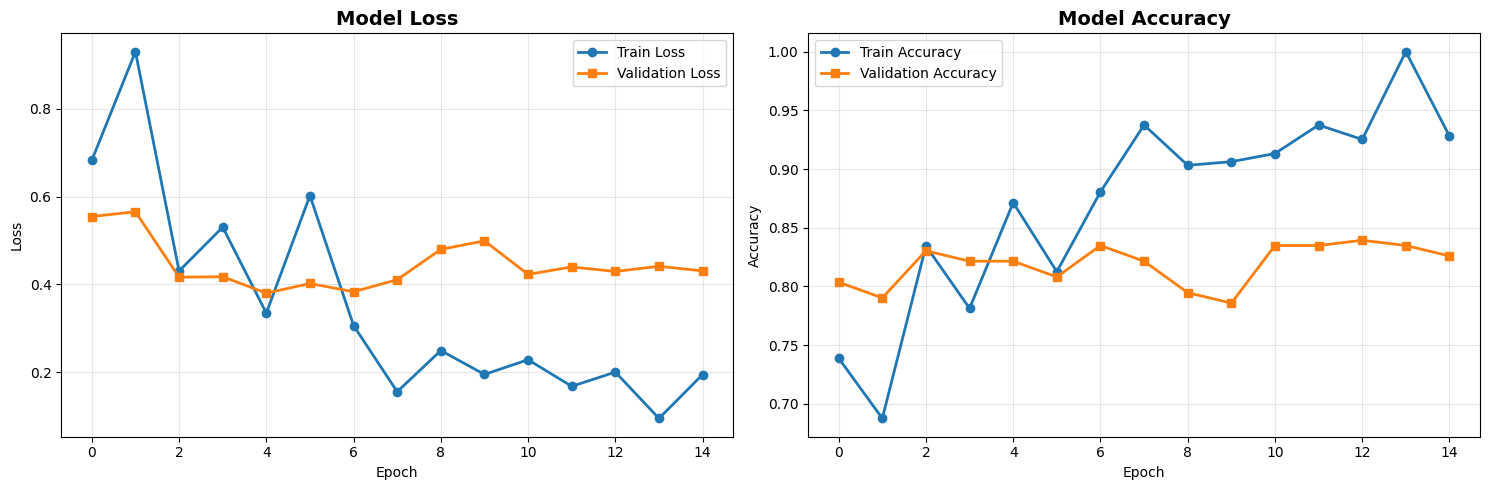

In [52]:
# Créer les graphiques d'entraînement
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(RESULTS_DIR, 'training_history_plot.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f" Graphique sauvegardé: {plot_path}")
plt.show()


## Résumé des performances

In [53]:
# Afficher un résumé des performances
print("\n" + "="*70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*70)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

print(f"   - Epochs effectués: {len(history.history['loss'])}")
print(f"   - Meilleure validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) - Epoch {best_epoch}")
print(f"   - Accuracy finale (train): {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   - Accuracy finale (validation): {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   - Loss finale (train): {history.history['loss'][-1]:.4f}")
print(f"   - Loss finale (validation): {history.history['val_loss'][-1]:.4f}")

# Afficher le learning rate final si disponible
if 'lr' in history.history:
    final_lr = history.history['lr'][-1]
    print(f"   - Learning rate final: {final_lr:.2e}")

print("="*70)
print(f"\n Modèle sauvegardé dans: {MODEL_SAVE_PATH}")



RÉSUMÉ DE L'ENTRAÎNEMENT
   - Epochs effectués: 15
   - Meilleure validation accuracy: 0.8393 (83.93%) - Epoch 13
   - Accuracy finale (train): 0.9280 (92.80%)
   - Accuracy finale (validation): 0.8259 (82.59%)
   - Loss finale (train): 0.1945
   - Loss finale (validation): 0.4306

 Modèle sauvegardé dans: results/model_xception_best.h5
